In this application we will explore a dataset from Kaggle that contains information on 400K used cars. 
The goal is to determine which factors make a car more or less expensive. 
And to provide clear recommendations on what consumers value in a used car.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge,Lasso
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler

from sklearn import set_config
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

Reading the data

In [2]:
car_data = pd.read_csv('data/vehicles.csv')

In [3]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [4]:
car_data.isnull().sum()

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

### Cleaning the data

These 2 columns does not impact car price prediction

In [5]:
cols=['VIN', 'id']
car_data.drop(columns=cols, axis=1, inplace=True)

Drop the columns when null count > 60%

In [6]:
def drop_missing_columns(car_data):
    mis_var = [var for var in car_data.columns if car_data[var].isnull().sum() > 0]
    car_data[mis_var].isnull().sum()
    limit = np.abs((car_data.shape[0] * 0.6))
    var_to_be_dropped = [var for var in mis_var if car_data[var].isnull().sum() > limit]
    car_data.drop(columns=var_to_be_dropped, axis=1, inplace=True)
    return car_data
drop_missing_columns(car_data)
car_data.isnull().sum()

region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
drive           130567
type             92858
paint_color     130203
state                0
dtype: int64

Drop the rows when multiple columns are null

In [7]:
cols = ["manufacturer","model"]
car_data[car_data[cols].isna().all(1)]
car_data.drop(car_data[car_data[cols].isna().all(1)].index,axis=0,inplace=True)

Extract car model

In [8]:
car_data['temp_model'] = car_data['model'].str.split(' ', expand=True)[0]
car_data['temp_model'] = car_data['temp_model'].astype(str)

manufacturer = Genesis & Scion added from the model

In [9]:
car_data.loc[car_data['temp_model'].isin(['Genesis','Scion']), 'manufacturer'] = car_data['temp_model']

Drop the rows where manufacturer column is null

In [10]:
car_data.dropna(subset=['manufacturer'],axis=0,inplace=True)

In [11]:
car_data.dropna(subset=['temp_model'],axis=0,inplace=True)

For tesla the letter followed by model is assigned for its model type

In [12]:
car_data["temp_model"] = np.where((car_data['manufacturer'] == 'tesla') & (car_data['temp_model'] == 'model'), car_data['model'].str.split(' ', expand=True)[1], car_data["temp_model"])

car_data["temp_model"] = car_data["temp_model"].str.replace("-", "")

car_data["temp_model"] = car_data["temp_model"].str.replace("sante", "santa")
car_data["temp_model"] = car_data["temp_model"].str.replace("santa+fe", "santa")
car_data["temp_model"] = car_data["temp_model"].str.replace("tuscon", "tucson")
car_data["temp_model"] = car_data["temp_model"].str.replace("tuscan", "tucson")
car_data["temp_model"] = car_data["temp_model"].str.replace("elentra", "elantra")
car_data["temp_model"] = car_data["temp_model"].str.replace("elantra", "elantra")
car_data["temp_model"] = car_data["temp_model"].str.replace("sonota", "sonata")

car_data["temp_model"] = car_data["temp_model"].str.replace("forrester", "forester")
car_data["temp_model"] = car_data["temp_model"].str.replace("forestor", "forester")
car_data["temp_model"] = car_data["temp_model"].str.replace("forrester", "forester")
car_data["temp_model"] = car_data["temp_model"].str.replace("foreser", "forester")
car_data["temp_model"] = car_data["temp_model"].str.replace("putback", "outback")
car_data["temp_model"] = car_data["temp_model"].str.replace("inpreza", "impreza")
car_data["temp_model"] = car_data["temp_model"].str.replace("imprza", "impreza")
car_data["temp_model"] = car_data["temp_model"].str.replace("impeza", "impreza")
car_data["temp_model"] = car_data["temp_model"].str.replace("imprezza", "impreza")


car_data["temp_model"] = car_data["temp_model"].str.replace("3.2", "tl")
car_data["temp_model"] = car_data["temp_model"].str.replace("3.2tl", "tl")
car_data["temp_model"] = car_data["temp_model"].str.replace("3.0cl", "cl")
car_data["temp_model"] = car_data["temp_model"].str.replace("3.5", "rl")
car_data["temp_model"] = car_data["temp_model"].str.replace("3.5rl", "rl")
car_data["temp_model"] = car_data["temp_model"].str.replace("2002", "mdx")
car_data["temp_model"] = car_data["temp_model"].str.replace("tltl", "tl")
car_data["temp_model"] = car_data["temp_model"].str.replace("rdxnsh/awd", "rdx")

car_data["temp_model"] = car_data["temp_model"].str.replace("08'", "mkz")
car_data["temp_model"] = car_data["temp_model"].str.replace("mkz/zephyr", "mkz")
car_data["temp_model"] = car_data["temp_model"].str.replace("6", "mkz")
car_data["temp_model"] = car_data["temp_model"].str.replace("limo", "limousine")
car_data["temp_model"] = car_data["temp_model"].str.replace("limousineusine", "limousine")
car_data["temp_model"] = car_data["temp_model"].str.replace("mkx(awd)limited", "mkx")
car_data["temp_model"] = car_data["temp_model"].str.replace("mkz,", "mkz")
car_data["temp_model"] = car_data["temp_model"].str.replace("/mercury,", "mkz")

car_data["temp_model"] = car_data["temp_model"].str.replace("outlander+sport", "outlander")
car_data["temp_model"] = car_data["temp_model"].str.replace("eclipse+cross", "eclipse")

car_data["temp_model"] = car_data["temp_model"].str.replace("cooper+s+countryman", "cooper")
car_data["temp_model"] = car_data["temp_model"].str.replace("cooper,", "cooper")
car_data["temp_model"] = car_data["temp_model"].str.replace("coopers", "cooper")
car_data["temp_model"] = car_data["temp_model"].str.replace("copper", "cooper")
car_data["temp_model"] = car_data["temp_model"].str.replace("2dr", "cooper")
car_data["temp_model"] = car_data["temp_model"].str.replace("deluxe", "cooper")
car_data["temp_model"] = car_data["temp_model"].str.replace("van", "cooper")
car_data["temp_model"] = car_data["temp_model"].str.replace("cargo", "cooper")
car_data["temp_model"] = car_data["temp_model"].str.replace("bus", "cooper")

car_data["temp_model"] = car_data["temp_model"].str.replace("g/mkz", "gmkz")
car_data["temp_model"] = car_data["temp_model"].str.replace("montana.", "montana")
car_data["temp_model"] = car_data["temp_model"].str.replace("montana/", "montana")

car_data["temp_model"] = car_data["temp_model"].str.replace("lr2/hse/nav", "lr2")
car_data["temp_model"] = car_data["temp_model"].str.replace("lr4/hse/nav", "lr4")
#car_data["temp_model"] = car_data["temp_model"].str.replace("hse**v8,", "hse")

car_data["temp_model"] = car_data["temp_model"].str.replace("911/99mkz", "911")
car_data["temp_model"] = car_data["temp_model"].str.replace("cayenne/4wd/nav..", "cayenne")
car_data["temp_model"] = car_data["temp_model"].str.replace("944,", "944")
car_data["temp_model"] = car_data["temp_model"].str.replace("caynne", "cayenne")

car_data["temp_model"] = car_data["temp_model"].str.replace("monterey￼", "monterey")
car_data["temp_model"] = car_data["temp_model"].str.replace("marineer,premier", "mariner")
car_data["temp_model"] = car_data["temp_model"].str.replace("marinr", "mariner")

car_data["temp_model"] = car_data["temp_model"].str.replace("sl2/sw2", "sl2")

car_data["temp_model"] = car_data["temp_model"].str.replace("romero", "romeo")
car_data["temp_model"] = car_data["temp_model"].str.replace("remeo", "romeo")

car_data["temp_model"] = car_data["temp_model"].str.replace("/", "500")
car_data["temp_model"] = car_data["temp_model"].str.replace("x1/9", "x1")

#car_data["temp_model"] = np.where((car_data['manufacturer'] == 'ford') , 'f-150', car_data["temp_model"])

#### Find the maximum model for car manufacture.

In [13]:
df = car_data.groupby(['manufacturer', 'temp_model']).size().reset_index(name='counts')
df_max = pd.DataFrame(df.groupby(['manufacturer'], sort=False)['counts'].max()).reset_index()
df_cd = pd.merge(df, df_max, how='inner', left_on = ['manufacturer','counts'], right_on = ['manufacturer','counts'])

In [14]:
car_data['temp_model'] = car_data['temp_model'].fillna(car_data['manufacturer'])
car_data['manufacturer'] = car_data['manufacturer'].fillna(car_data['temp_model'])

In [15]:
car_data.isnull().sum()

region               0
price                0
year                 6
manufacturer         0
model             5208
condition       167533
cylinders       171070
fuel              2559
odometer          4160
title_status      7772
transmission      2292
drive           123637
type             86463
paint_color     124491
state                0
temp_model           0
dtype: int64

Fill the null values for the features - condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color

In [16]:
car_data['condition'] = car_data['condition'].fillna(car_data.condition.mode()[0])
car_data['cylinders'] = car_data['cylinders'].fillna(car_data.cylinders.mode()[0])
car_data['fuel'] = car_data['fuel'].fillna(car_data.fuel.mode()[0])
car_data['odometer'] = car_data['odometer'].fillna(car_data.odometer.mode()[0])
car_data['title_status'] = car_data['title_status'].fillna(car_data.title_status.mode()[0])
car_data['transmission'] = car_data['transmission'].fillna(car_data.transmission.mode()[0])
car_data['drive'] = car_data['drive'].fillna(car_data.drive.mode()[0])
car_data['type'] = car_data['type'].fillna(car_data.type.mode()[0])
car_data['paint_color'] = car_data['paint_color'].fillna(car_data.paint_color.mode()[0])
car_data['year'] = car_data['year'].fillna(car_data.year.mode()[0])

Dropping the model after getting the model details

In [17]:
car_data.dropna(subset=['model'],axis=0,inplace=True)

In [18]:
car_data.loc[car_data['cylinders'] == 'other','cylinders'] = '20 cylinders'
car_data['cylinders'] = car_data['cylinders'].str.split(' ', expand=True)[0]
car_data['cylinders'] = car_data['cylinders'].astype('int64')
car_data['cylinders'].value_counts()

6     258937
4      74814
8      67982
5       1558
10      1333
20       906
3        556
12       119
Name: cylinders, dtype: int64

Dropping the data samples with odometer & price with 0 values as this application focuses on recommending the used car dealers to build their inventory.

In [19]:
car_data.drop(car_data.query('odometer == 0').index,axis=0,inplace=True)

In [20]:
car_data.drop(car_data.query('price == 0').index,axis=0,inplace=True)

#### Removing outliers

Drop the data samples price < 100
Drop the data samples price >  80000 and  manufacturer not in ferrari/ mercedes-benz/ porsche/ jaguar/ aston-martin/bmw

In [21]:
car_data.drop(car_data.query('price < 100').index,axis=0,inplace=True)

manufacturer_to_keep = ['ferrari','mercedes-benz','porsche','jaguar','aston-martin','bmw']
car_data.drop(car_data.query('price >  80000 and  manufacturer not in @manufacturer_to_keep').index,axis=0,inplace=True)

Drop outliers with price > 500000, mercedes-benz has 2 datasets with big number
For the manufactures in the dataset the maximum used car price could not be > 500000

In [22]:
car_data.drop(car_data.query('price > 500000').index,axis=0,inplace=True)

Considering only the car year > 1990. Vintage car categories are not considered

In [23]:
car_data.drop(car_data.query('year < 1990').index,axis=0,inplace=True)

In [24]:
car_data.describe()

,price,year,cylinders,odometer
count,362073.000000,362073.000000,362073.000000,3.620730e+05
mean,18908.228200,2012.429311,5.972329,9.554214e+04
std,14272.604721,5.732808,1.365514,1.345854e+05
min,100.000000,1990.000000,3.000000,1.000000e+00
25%,7500.000000,2009.000000,6.000000,3.914600e+04
50%,15900.000000,2014.000000,6.000000,8.834900e+04
75%,27900.000000,2017.000000,6.000000,1.352830e+05
max,449500.000000,2022.000000,20.000000,1.000000e+07


In [25]:
car_data['year'] = car_data['year'].astype('int64')
car_data['years_old'] = 2022 - car_data['year']

Categorical count plots

In [26]:
car_data.groupby(['cylinders'])['price'].agg(['mean','median','count','sum','max','min']).sort_values(by = 'mean',ascending=False)

,mean,median,count,sum,max,min
cylinders,,,,,,
12,36626.990385,19250.0,104,3809207,289995,203
8,23903.958380,21995.0,57833,1382437625,349999,100
20,23177.435685,17000.0,723,16757286,130000,109
10,21084.682836,19999.0,1072,22602780,72975,153
6,20024.490138,17590.0,231496,4635589369,449500,100
3,14391.860558,10998.0,502,7224714,128995,106
4,11130.137084,8999.0,68870,766532541,89000,100
5,7607.187373,6000.0,1473,11205387,79999,112


### Data Analysis

<Figure size 720x288 with 0 Axes>

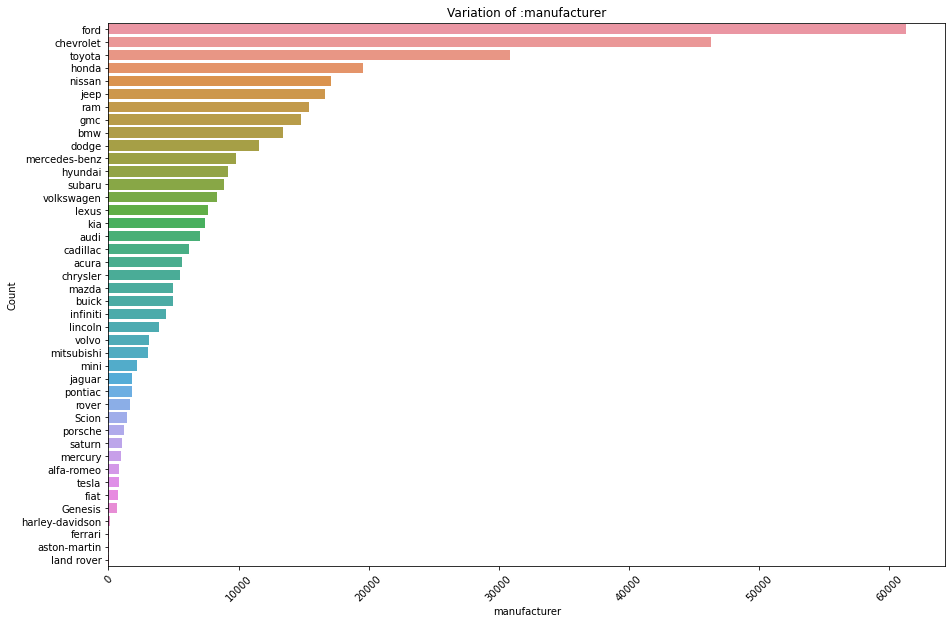

<Figure size 720x288 with 0 Axes>

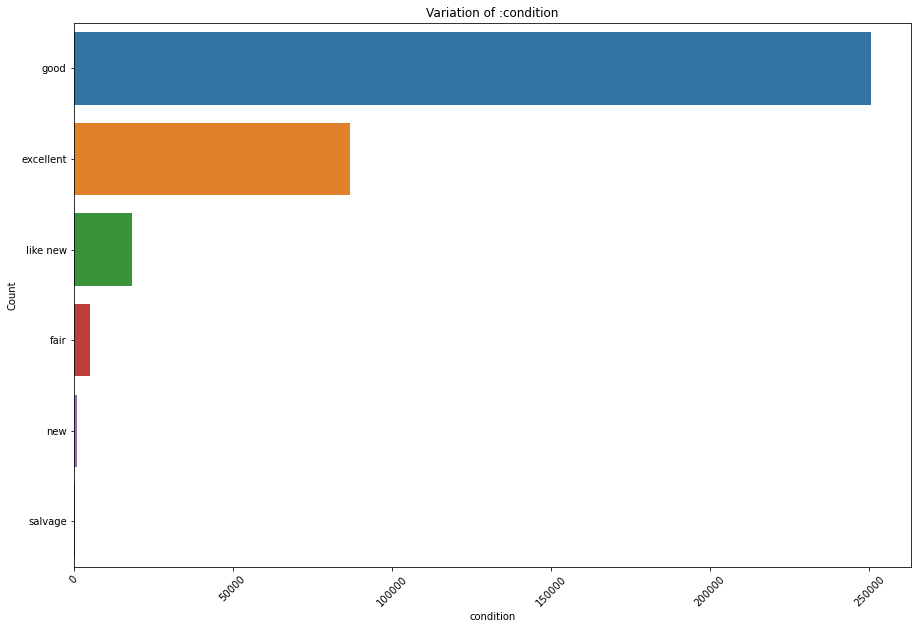

<Figure size 720x288 with 0 Axes>

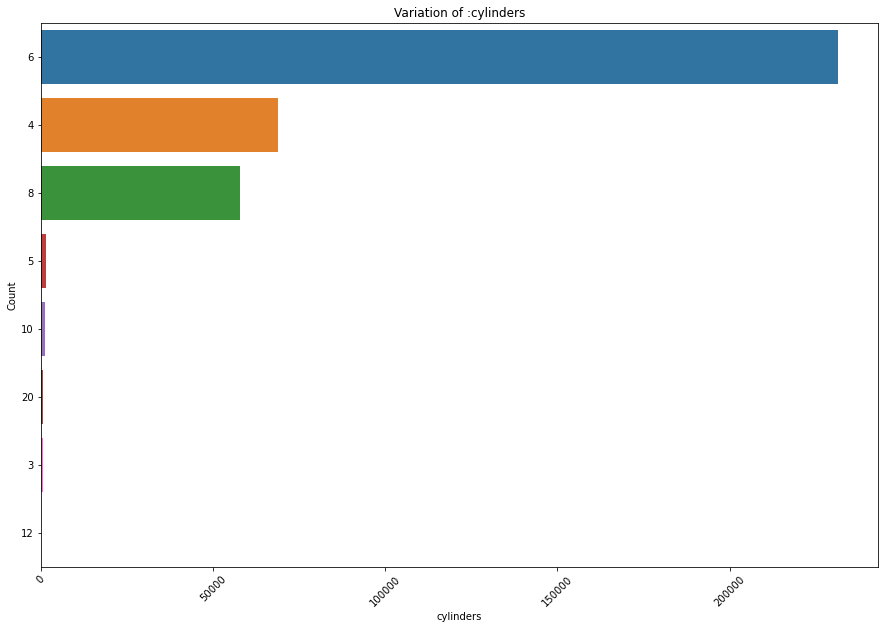

<Figure size 720x288 with 0 Axes>

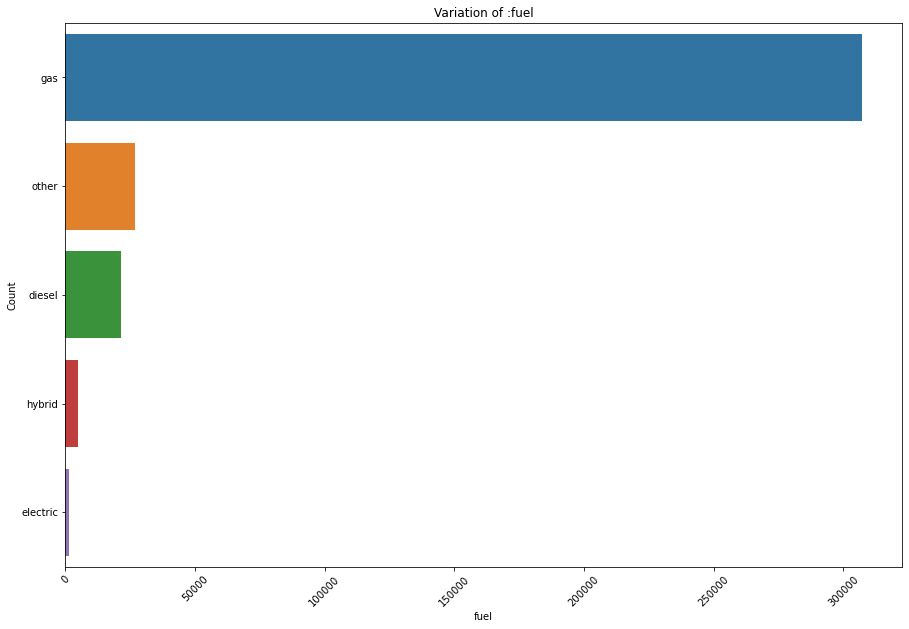

<Figure size 720x288 with 0 Axes>

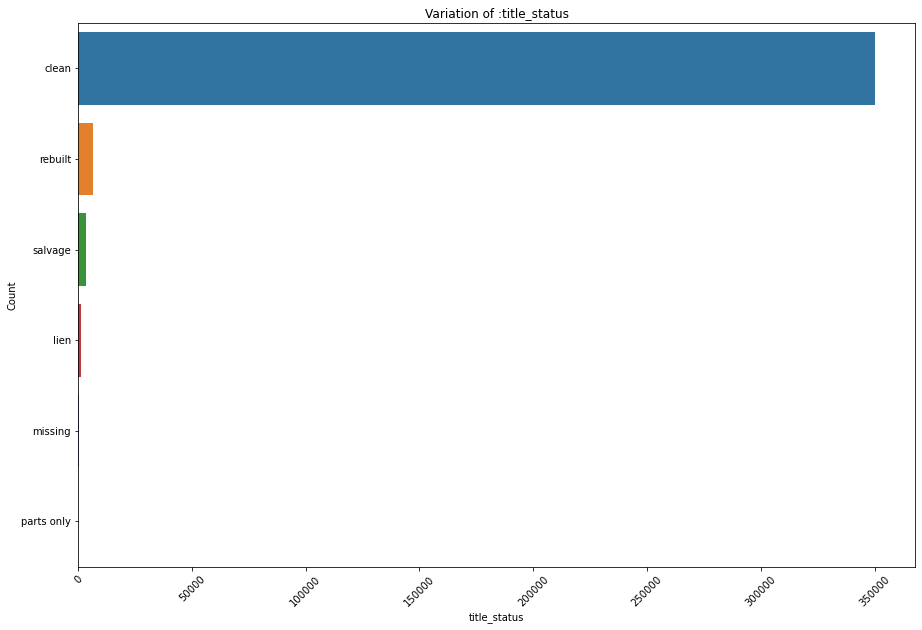

<Figure size 720x288 with 0 Axes>

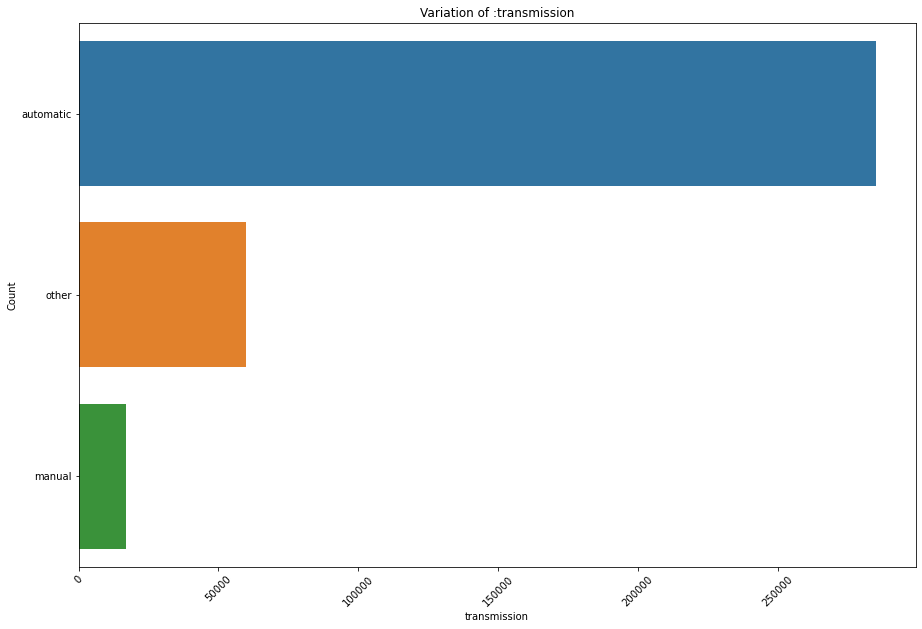

<Figure size 720x288 with 0 Axes>

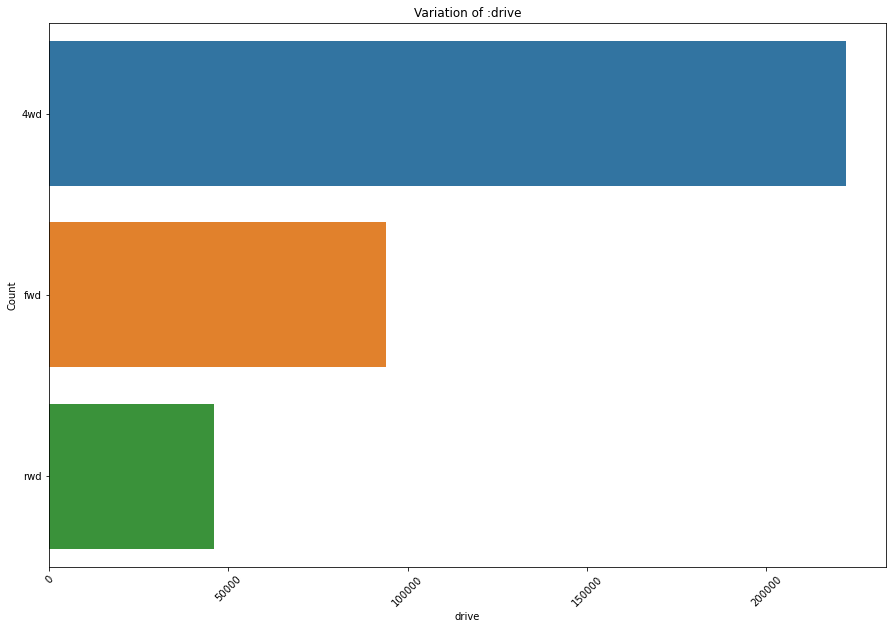

<Figure size 720x288 with 0 Axes>

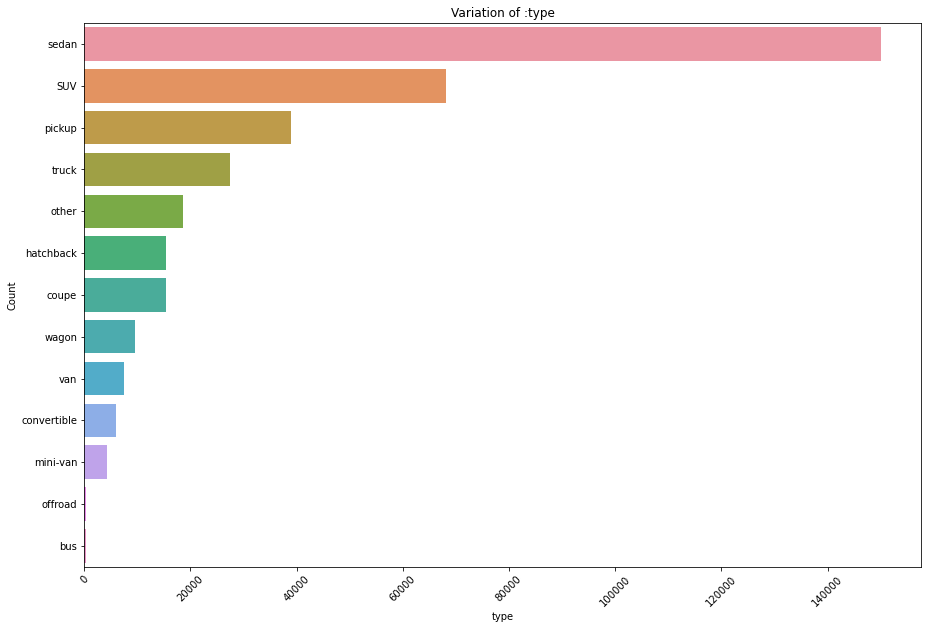

<Figure size 720x288 with 0 Axes>

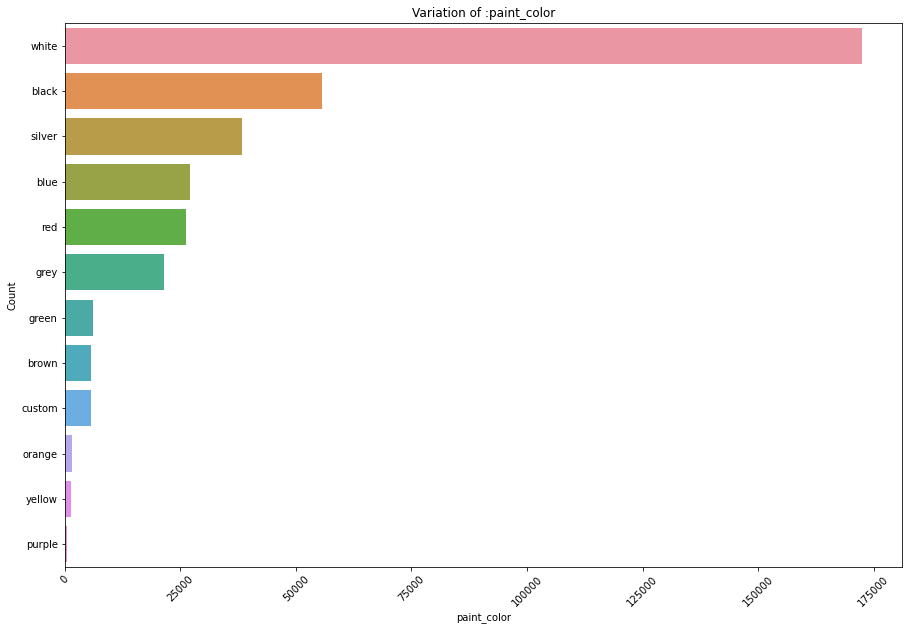

<Figure size 720x288 with 0 Axes>

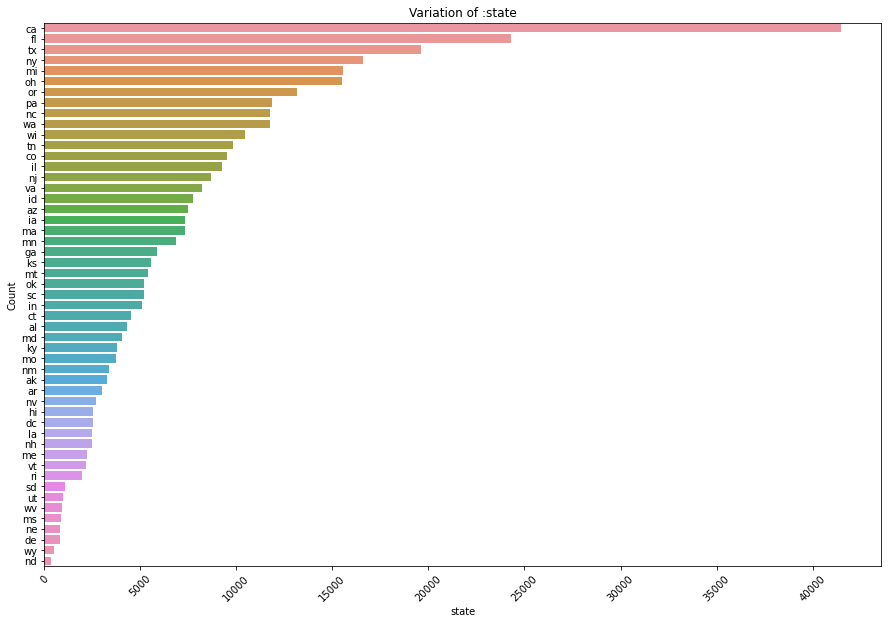

In [27]:
def analyze_cont_vars(df,var):
    
    new_df = df.copy()
    fig, ax = plt.subplots(figsize=(15, 10))
    ax = sns.countplot(y=var, data=new_df, order = new_df[var].value_counts().index, ax = ax)
    plt.xlabel(var)
    plt.xticks(rotation=45)
    plt.ylabel('Count')
    plt.title('Variation of :'+ var)
    plt.show()
    
columns_to_plot = car_data[['manufacturer','condition','cylinders','fuel','title_status','transmission','drive','type','paint_color','state']]

for var in columns_to_plot:
    plt.figure(figsize=(10,4))
    analyze_cont_vars(columns_to_plot,var)

Maximum used cars are  5 to 14 years old

In [28]:
car_data['year'].value_counts().head(35)

2018    31717
2017    31524
2013    27078
2015    26815
2016    26501
2014    25996
2019    22366
2012    21241
2011    18324
2020    17140
2008    15259
2010    14257
2007    13238
2006    11154
2009    10984
2005     9460
2004     8115
2003     6401
2002     5019
2001     3886
2000     3101
1999     2639
1998     1713
2021     1548
1997     1472
1996     1086
1995     1031
1994      816
1993      602
1991      520
1990      504
1992      501
2022       65
Name: year, dtype: int64

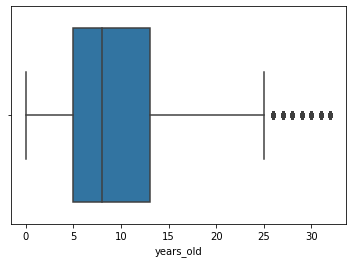

In [29]:
ax = sns.boxplot(x=car_data["years_old"])

In [30]:
bins = [0, 100, 1000, 5000, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000, 140000, 150000, 175000, 200000,400000000]

groups = ['< 100', '100 - 1000', '1000 - 5000', '5000 - 10000', '10000 - 20000', '20000 - 30000', '30000 - 40000', '40000 - 50000', '50000 - 60000', '60000 - 70000', '70000 - 80000', '80000 - 90000', '90000 - 100000', '100000 - 110000', '110000 - 120000', '120000 - 130000','130000 - 140000', '140000 - 150000','150000 - 175000', '175000 - 200000', '200000 +']
car_data['odometer_range'] = pd.cut(car_data['odometer'],bins,labels = groups)

<AxesSubplot:xlabel='Count', ylabel='odometer_range'>

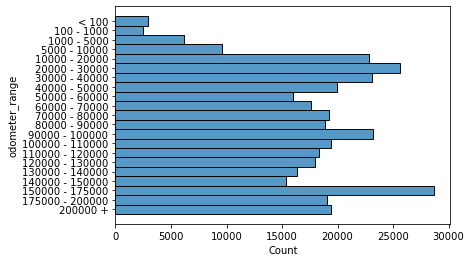

In [31]:
sns.histplot(binwidth=0.5, y="odometer_range", data=car_data, stat="count", multiple="stack")

In [32]:
car_data.groupby(['odometer_range'])['price'].agg(['mean','median','count','sum','max','min']).sort_values(by = 'mean',ascending=False)

,mean,median,count,sum,max,min
odometer_range,,,,,,
1000 - 5000,34977.799480,34249.5,6154,215253378,349999,123
5000 - 10000,34343.934588,34590.0,9616,330251275,239995,150
10000 - 20000,31312.993265,29990.0,22866,716002904,227995,100
20000 - 30000,29900.320884,29500.0,25623,766135922,164900,101
30000 - 40000,27818.668083,26972.0,23060,641498486,204999,100
40000 - 50000,25386.328838,23990.0,19946,506355715,149990,100
50000 - 60000,24161.127577,20999.0,16006,386723008,149995,100
100 - 1000,21882.784170,16995.0,2451,53634704,449500,123
60000 - 70000,21606.496004,18749.0,17641,381160196,139888,100


In [33]:
bins = [0, 100, 1000, 5000, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000, 140000, 150000, 175000, 200000,400000000]

groups = ['< 100', '100 - 1000', '1000 - 5000', '5000 - 10000', '10000 - 20000', '20000 - 30000', '30000 - 40000', '40000 - 50000', '50000 - 60000', '60000 - 70000', '70000 - 80000', '80000 - 90000', '90000 - 100000', '100000 - 110000', '110000 - 120000', '120000 - 130000','130000 - 140000', '140000 - 150000','150000 - 175000', '175000 - 200000', '200000 +']
car_data['price_range'] = pd.cut(car_data['price'],bins,labels = groups)

Maximum used car price is 10K - 20K

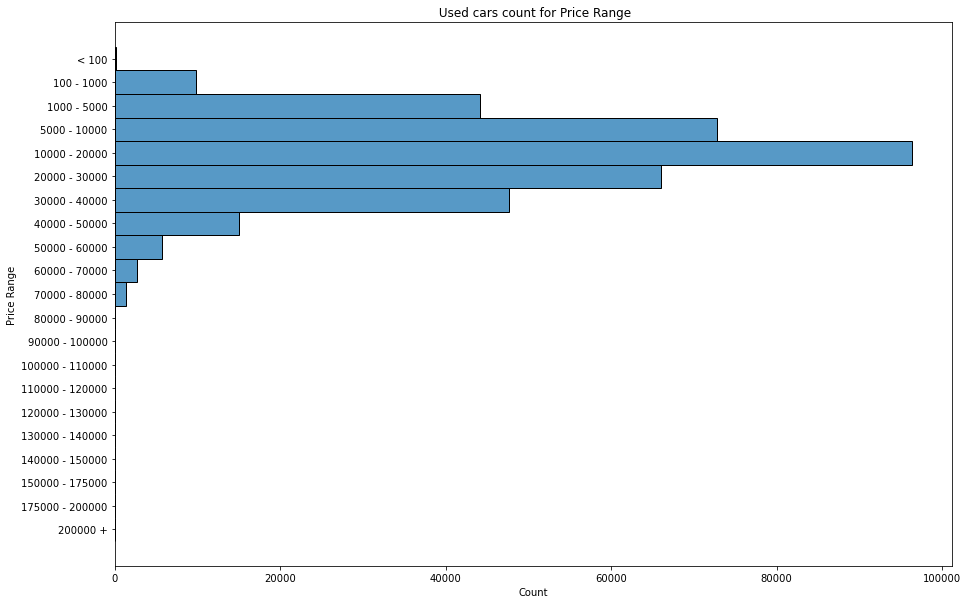

In [34]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.histplot(binwidth=0.5, y="price_range", data=car_data, stat="count", multiple="stack",ax=ax)
plt.xlabel('Count')
plt.ylabel('Price Range')
plt.title(' Used cars count for Price Range')
plt.show()

Maximum sold cars are with odometer reading - 150K - 175K & 20K - 30K

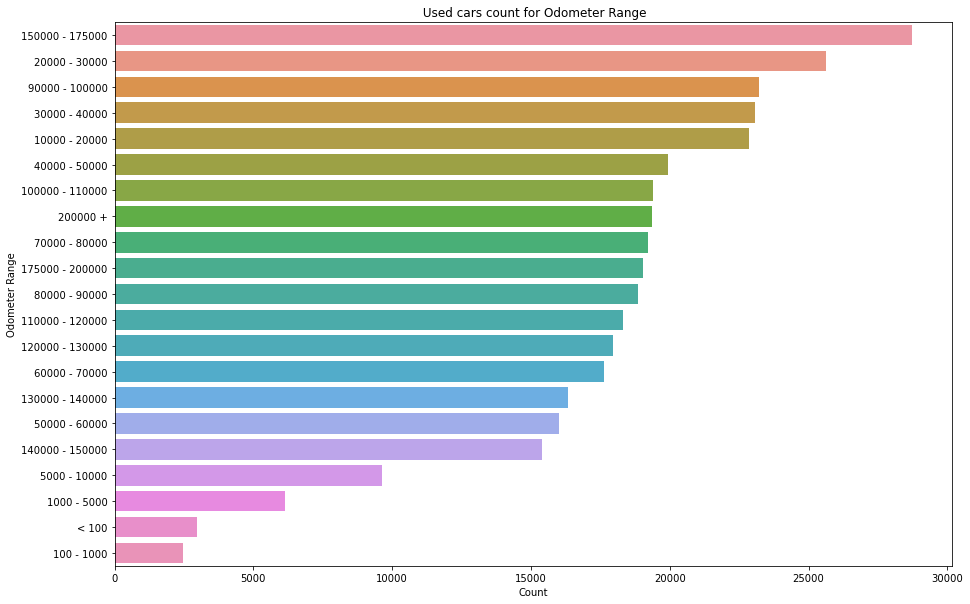

In [35]:
fig, ax = plt.subplots(figsize=(15, 10))
#sns.histplot(binwidth=0.5, y="odometer_range", data=car_data, stat="count", multiple="stack",ax = ax)
sns.countplot(data= car_data, y='odometer_range',order = car_data['odometer_range'].value_counts().index)
plt.xlabel('Count')
plt.ylabel('Odometer Range')
plt.title(' Used cars count for Odometer Range')
plt.show()

Number of years old car VS count

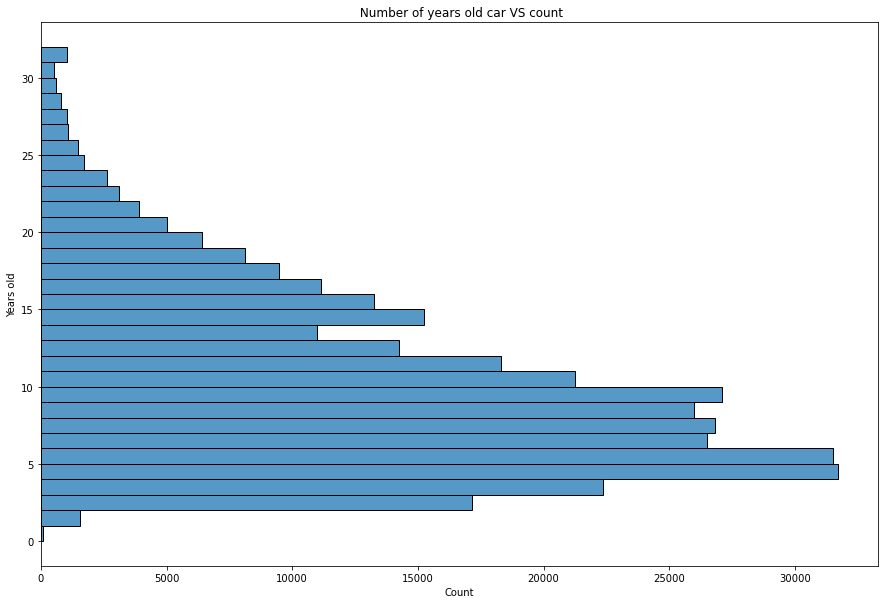

In [36]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.histplot(binwidth=1, y="years_old", data=car_data, stat="count", multiple="stack",ax=ax)
plt.xlabel('Count')
plt.ylabel('Years old')
plt.title(' Number of years old car VS count')
plt.show()

Odometer vs Price for some of the models

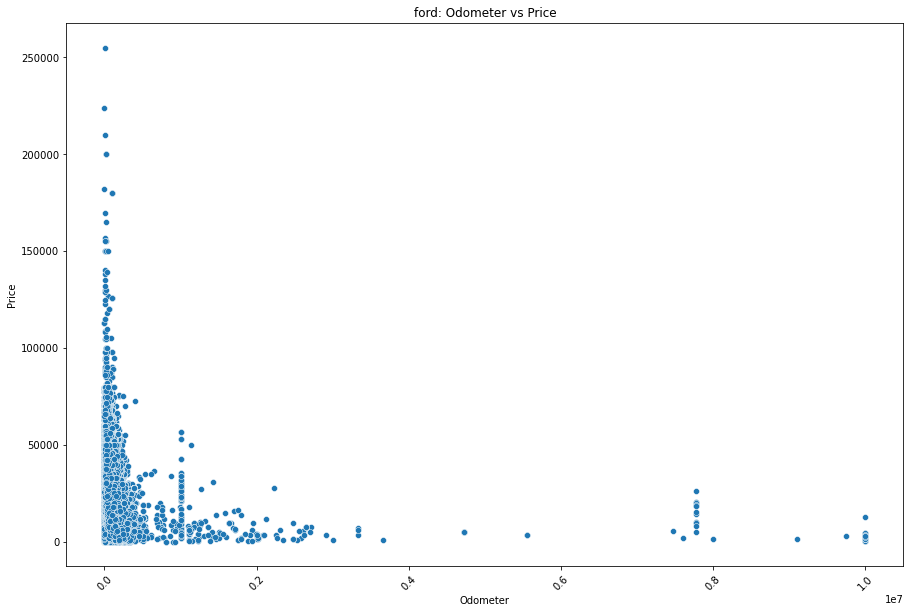

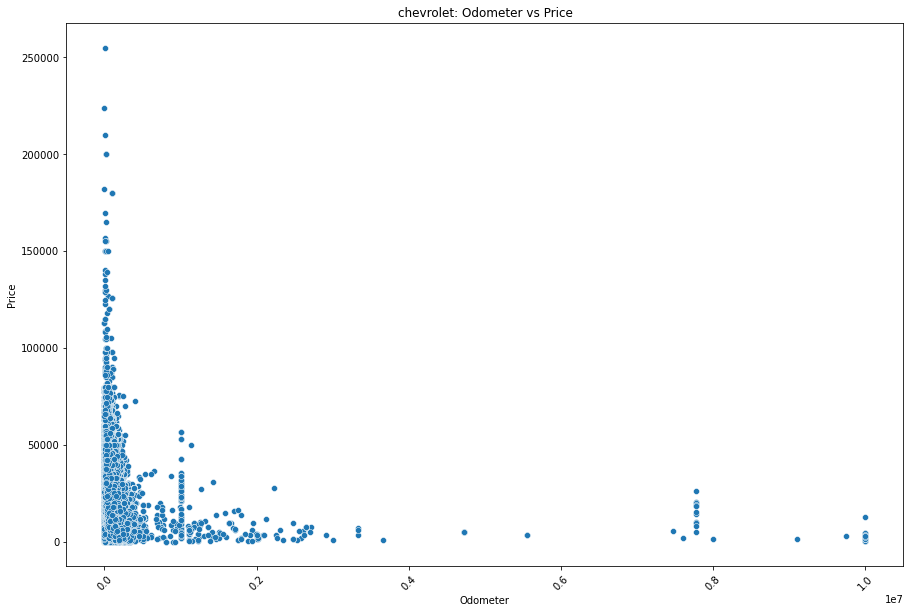

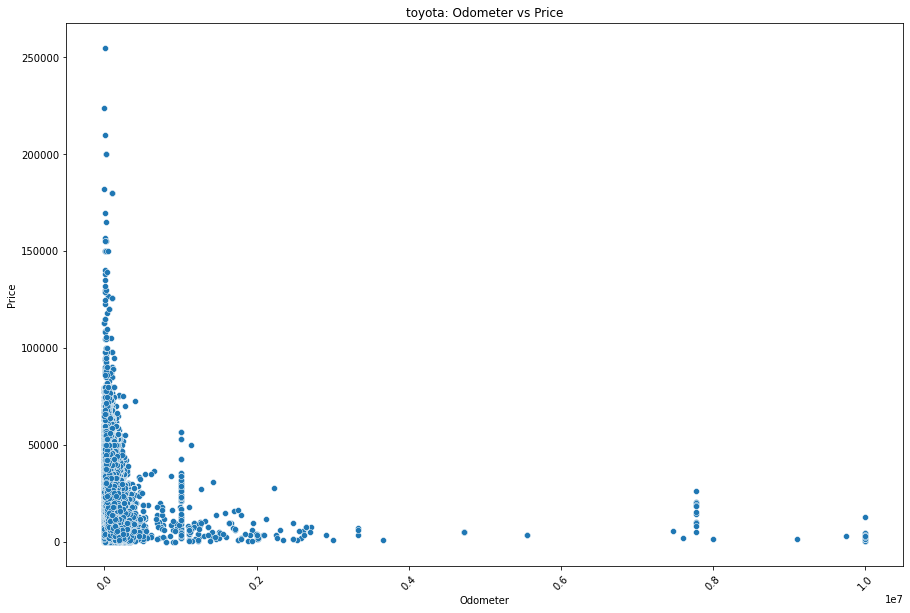

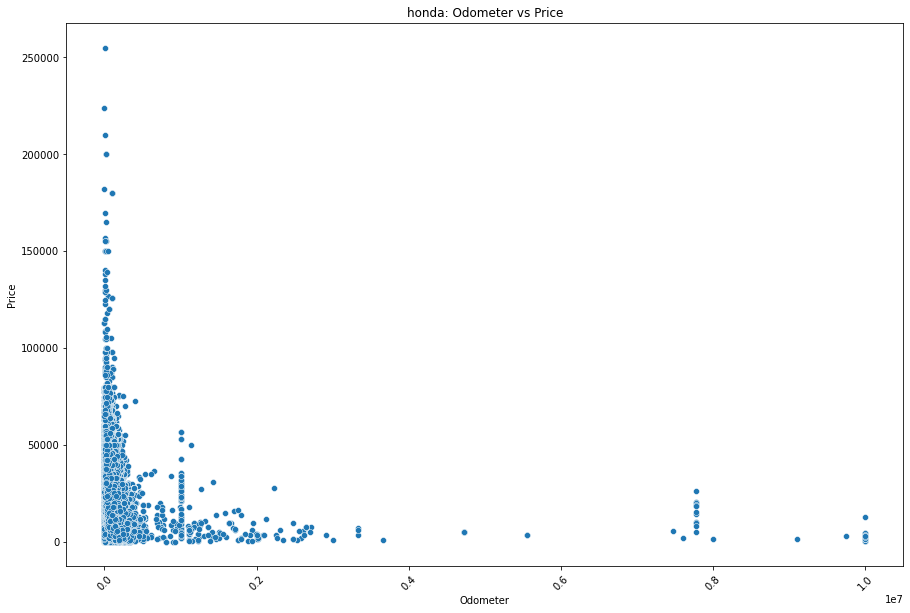

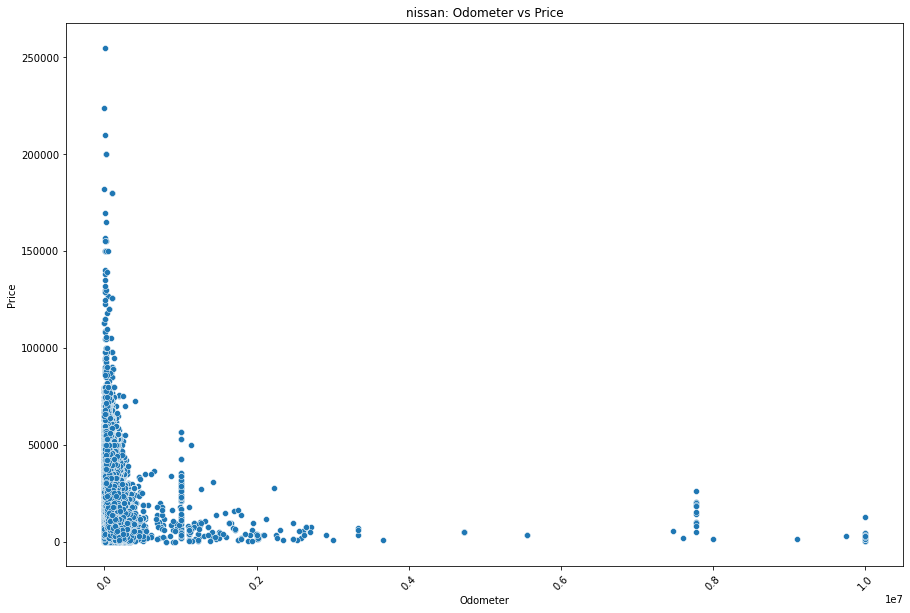

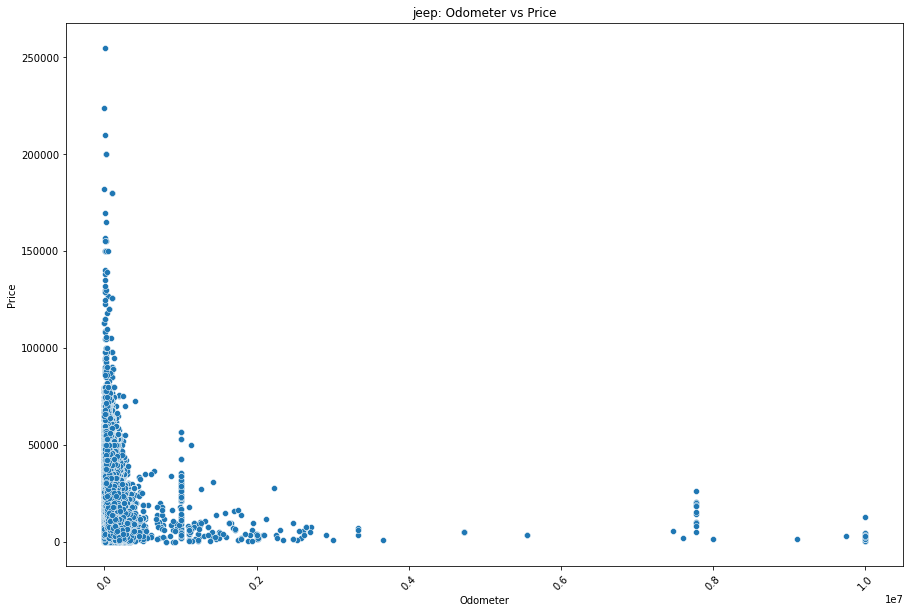

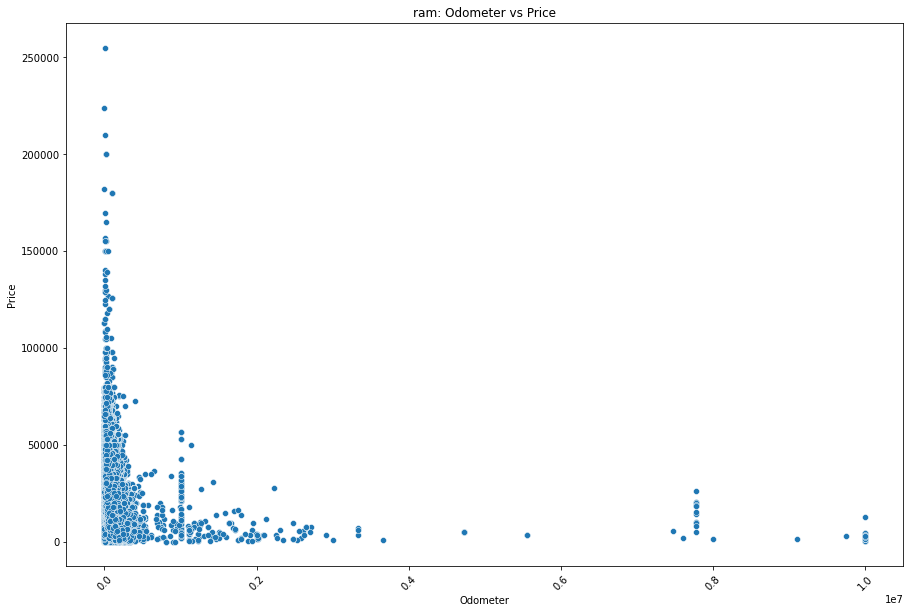

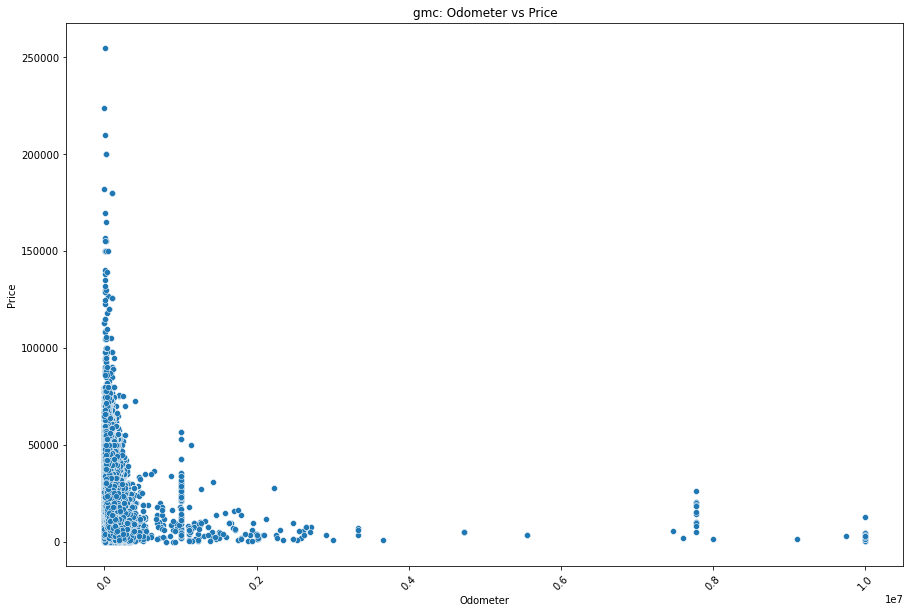

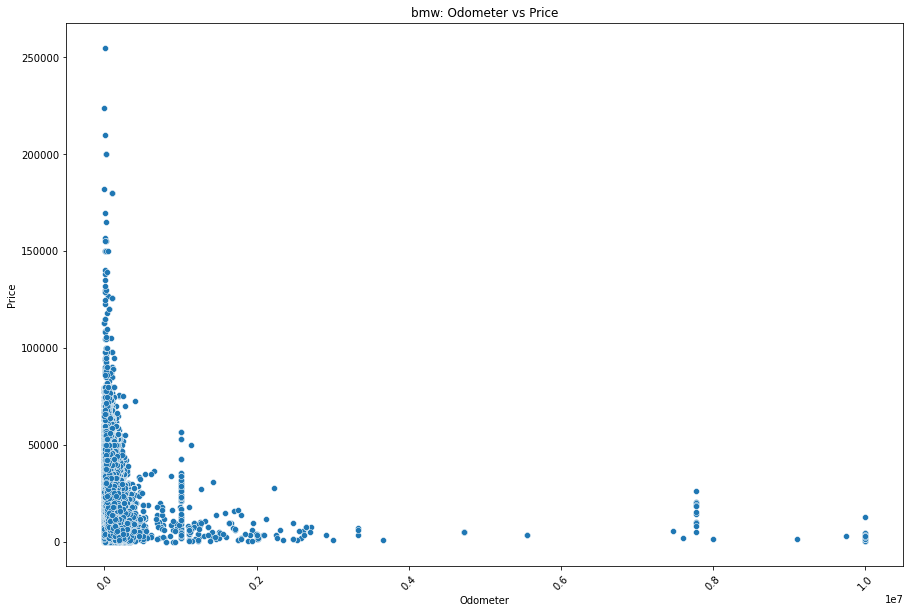

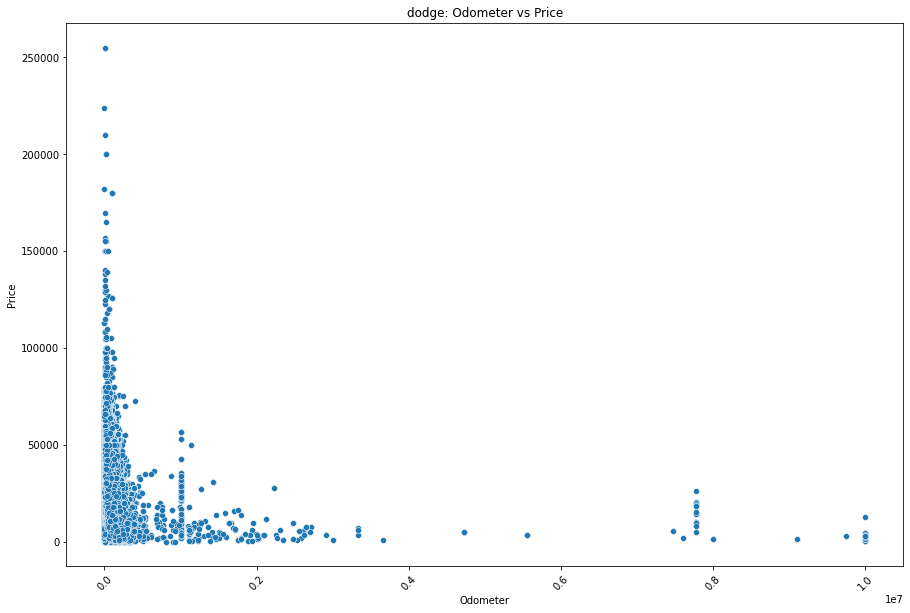

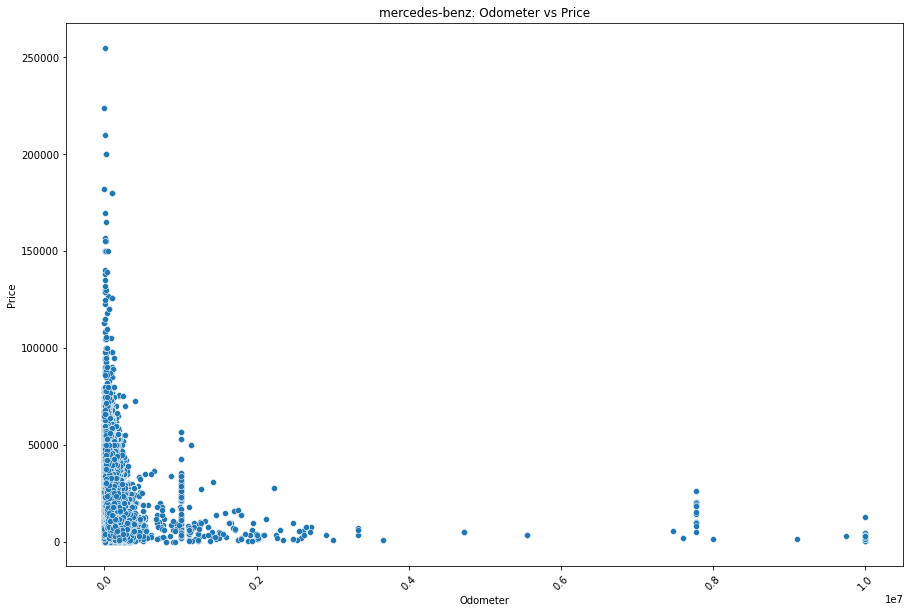

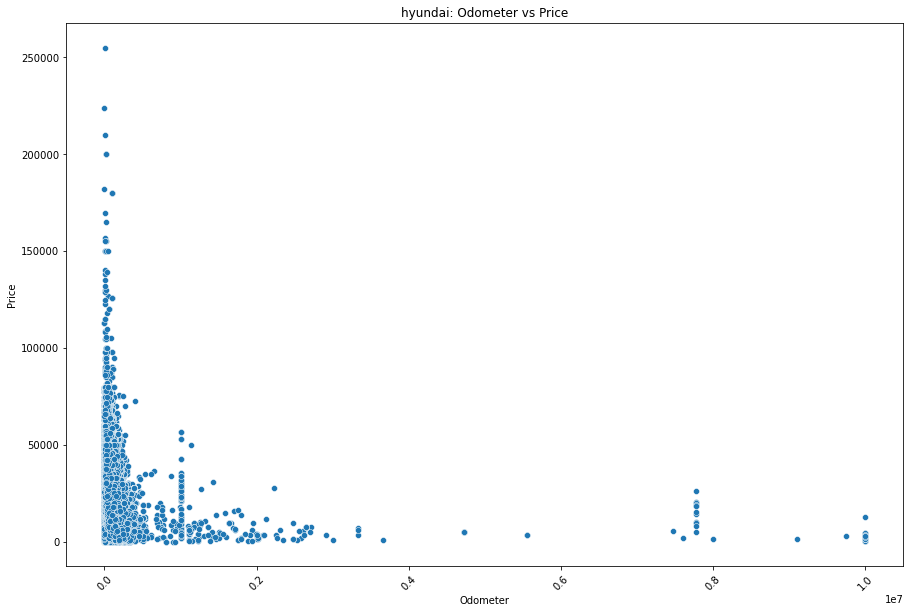

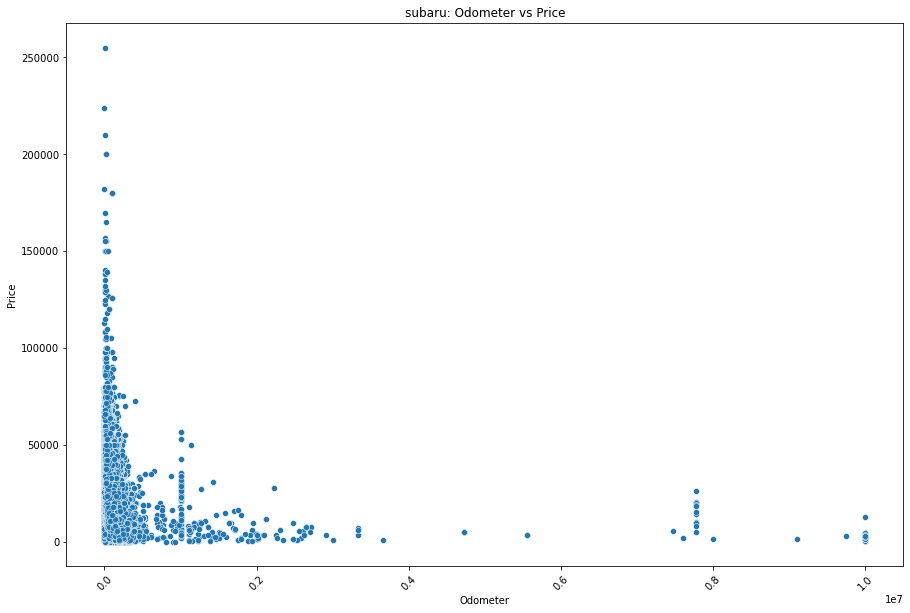

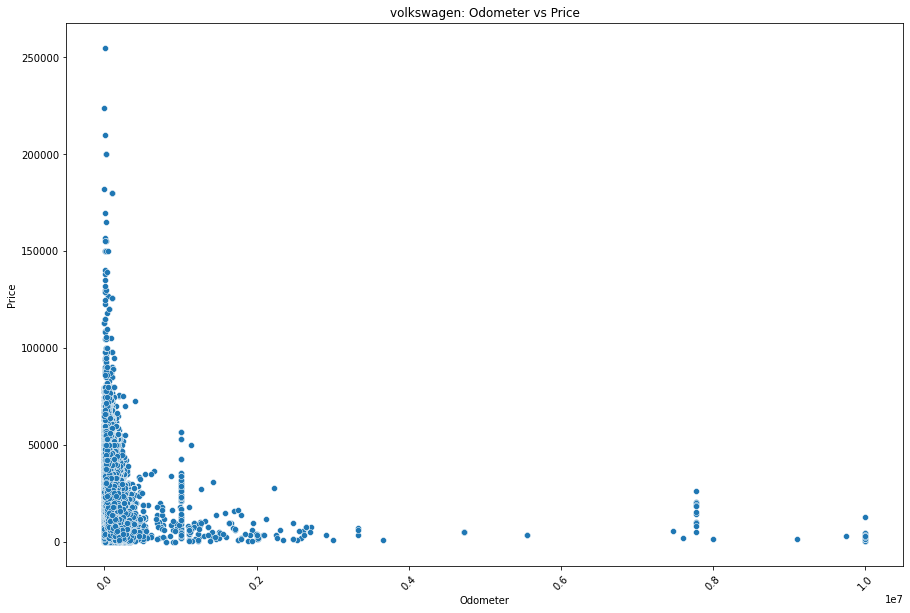

In [37]:
manu_to_plot = ['ford','chevrolet','toyota','honda','nissan','jeep','ram','gmc','bmw','dodge','mercedes-benz','hyundai','subaru','volkswagen' ]
for var in manu_to_plot:
    temp = car_data.query('manufacturer == @manu_to_plot')
    fig, ax = plt.subplots(figsize=(15, 10))
    ax = sns.scatterplot(x='odometer',y='price',data=temp, ax = ax)
    plt.xlabel(var)
    plt.xticks(rotation=45)
    plt.xlabel('Odometer')
    plt.ylabel('Price')
    plt.title(var + ': Odometer vs Price')
    plt.show()


Outliers - odometer
odometer > 300000, the value is defaulted to 300000 
The maximum used cars odometer is in the range 35k - 140K

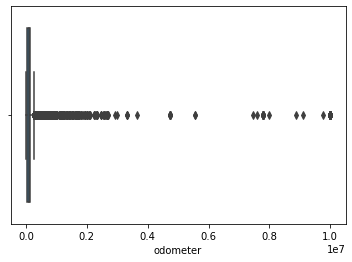

In [38]:
ax = sns.boxplot(x=car_data["odometer"])

Assigning categorical codes for categorical features

In [39]:
car_data['condition_code'] = car_data['condition'].astype('category').cat.codes
car_data['fuel_code'] = car_data['fuel'].astype('category').cat.codes
car_data['title_status_code'] = car_data['title_status'].astype('category').cat.codes
car_data['transmission_code'] = car_data['transmission'].astype('category').cat.codes
car_data['drive_code'] = car_data['drive'].astype('category').cat.codes
car_data['type_code'] = car_data['type'].astype('category').cat.codes
car_data['paint_color_code'] = car_data['paint_color'].astype('category').cat.codes
car_data['manufacturer_code'] = car_data['manufacturer'].astype('category').cat.codes
car_data['temp_model_code'] = car_data['temp_model'].astype('category').cat.codes
car_data['region_code'] = car_data['region'].astype('category').cat.codes

car_data['odometer_initial'] = car_data['odometer']
car_data['price_initial'] = car_data['price']

The 5 manufacturers with high price are ferrari, aston-martin, porsche, mercedes-benz, bmw

In [40]:
car_data[car_data['price_initial'] > 100000]['manufacturer'].value_counts()

mercedes-benz    51
ferrari          41
porsche          31
bmw               6
aston-martin      3
Name: manufacturer, dtype: int64

The below table will help to decide the inventory

In [41]:
car_luxury = car_data.groupby(['manufacturer'])['price_initial'].agg(['mean','median','count','sum','max','min']).sort_values(by = 'mean',ascending=False)
car_luxury

,mean,median,count,sum,max,min
manufacturer,,,,,,
ferrari,147819.465517,122450.0,58,8573529,449500,2034
aston-martin,61136.619048,52000.0,21,1283869,179888,1947
tesla,38422.816728,37990.0,813,31237750,80000,348
porsche,34581.780591,29997.0,1185,40979410,304995,100
Genesis,33867.797317,33590.0,671,22725292,47590,525
ram,30451.150340,30590.0,15425,469708994,80000,101
alfa-romeo,29985.669868,29800.0,833,24978063,54998,1000
jaguar,27773.624309,28990.0,1810,50270260,65000,134
rover,27351.325030,24999.0,1646,45020281,79950,101


In [42]:
car_data.groupby(['condition'])['price_initial'].agg(['median','count','sum'])#.sort_values(ascending=False).head(45)

,median,count,sum
condition,,,
excellent,11950.0,86874,1320458804
fair,2500.0,4992,17708563
good,17999.0,250506,5142293620
like new,14500.0,18344,341026908
new,20132.5,890,22846637
salvage,2000.0,467,1824377


Whent he dealer decides to open new used car show room, the below region wise table will help the dealer to solve the new location specific questions.
The below one is for California location.

In [43]:
car_data.query('state == "ca"').groupby(['region'])['price_initial'].sum().sort_values(ascending=False)

region
bakersfield         52518870
reno / tahoe        48732373
fresno / madera     45675945
SF bay area         45608763
stockton            45232094
redding             42998344
sacramento          42316586
modesto             42040623
orange county       41488617
los angeles         39791099
san diego           36968740
ventura county      34841555
inland empire       29424033
monterey bay        27011887
palm springs        25767239
yuba-sutter         25579464
chico               25503838
san luis obispo     23456460
visalia-tulare      20970500
santa barbara       18211058
merced              12249428
gold country        10991096
santa maria         10906664
humboldt county      5486636
imperial county      4311144
hanford-corcoran     3838345
susanville           2419800
mendocino county     2147531
siskiyou county       573956
Name: price_initial, dtype: int64

Lists the State wise car sale count for manufacture = ford

In [44]:
car_data.query('manufacturer == "ford"').groupby(['state'])['state'].count().sort_values(ascending=False).head(51)

state
ca    5871
fl    4480
tx    3917
mi    3543
oh    2751
or    2587
ny    2265
wa    2001
tn    1878
nc    1821
pa    1761
wi    1749
il    1547
co    1490
ia    1428
mn    1402
id    1400
va    1352
az    1185
nj    1134
ma    1133
mt    1014
ks     988
ok     932
in     923
ga     893
al     847
sc     763
ky     699
mo     653
ct     613
ak     543
md     536
nm     525
ar     459
la     434
me     422
nh     377
vt     345
nv     337
sd     270
dc     268
hi     263
ri     257
ne     241
ut     225
wv     215
de     151
ms     145
wy     116
nd      98
Name: state, dtype: int64

Top 30 Maximum Manufacture sold by State

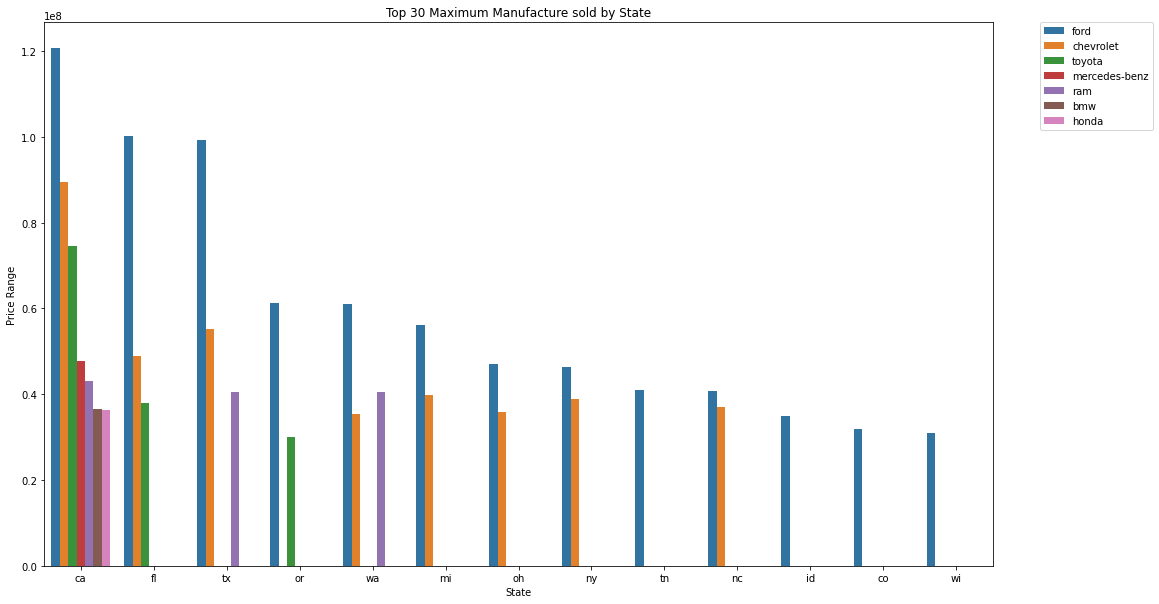

In [45]:
fig, ax = plt.subplots(figsize=(17, 10))
car_top_30_manu_state = pd.DataFrame(car_data.groupby(['state','manufacturer'])['price_initial'].sum().sort_values(ascending=False).head(30)).reset_index()
sns.barplot(x="state",y='price_initial',hue='manufacturer', data=car_top_30_manu_state,ax=ax)
plt.xlabel('State')
plt.ylabel('Price Range')
plt.title('Top 30 Maximum Manufacture sold by State')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Top 30 Used Car Models sold

Text(0.5, 1.0, 'Top 30 Used Car Models sold')

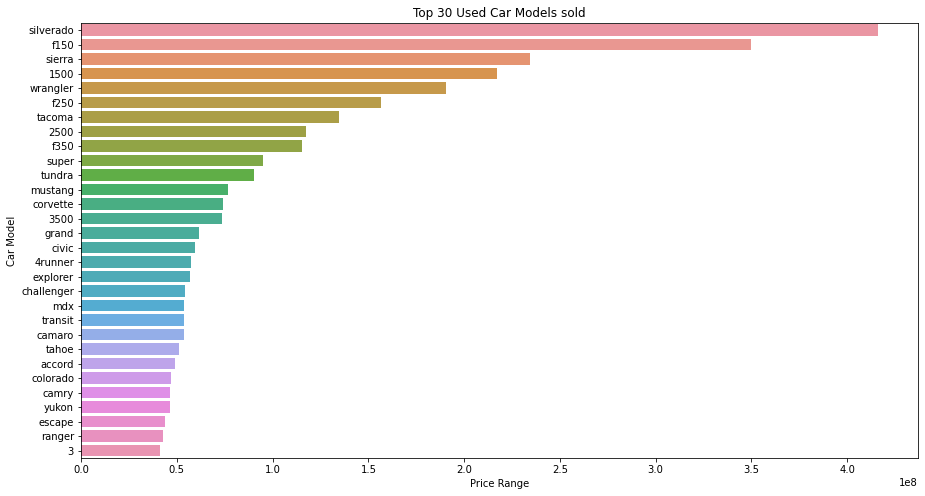

In [46]:
car_top_300_models = pd.DataFrame(car_data.groupby(['manufacturer','temp_model'])['price_initial'].sum().sort_values(ascending=False).head(30)).reset_index()
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(y="temp_model",x='price_initial', data=car_top_300_models,ax=ax)
plt.ylabel('Car Model')
plt.xlabel('Price Range')
plt.title('Top 30 Used Car Models sold')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Top 30 Used Car Manufacturer sold

Text(0.5, 1.0, 'Top 30 Used Car Manufacturer sold')

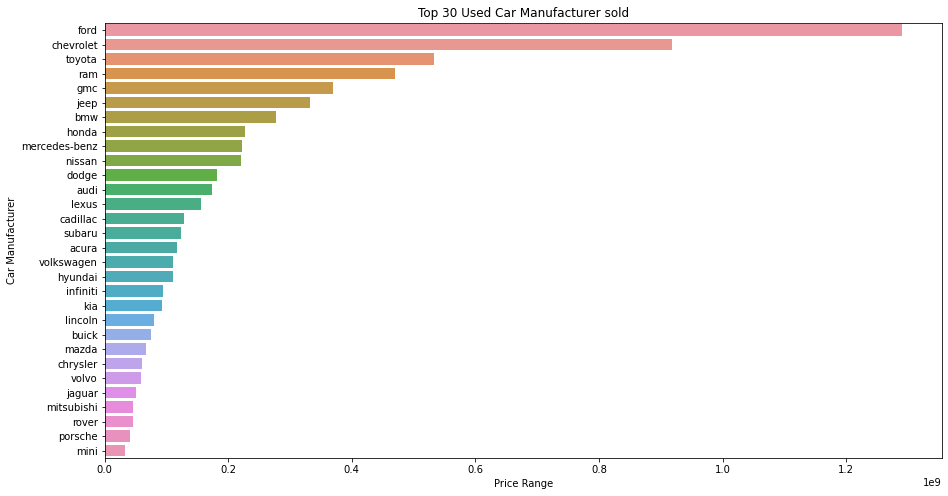

In [47]:
car_manufacturer_list = pd.DataFrame(car_data.groupby(['manufacturer'])['price_initial'].sum().sort_values(ascending=False).head(30)).reset_index()
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(y="manufacturer",x='price_initial', data=car_manufacturer_list,ax=ax)
plt.ylabel('Car Manufacturer')
plt.xlabel('Price Range')
plt.title('Top 30 Used Car Manufacturer sold')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Top 30 Used Car sold per State

Text(0.5, 1.0, 'Top 30 Used Car sold per State')

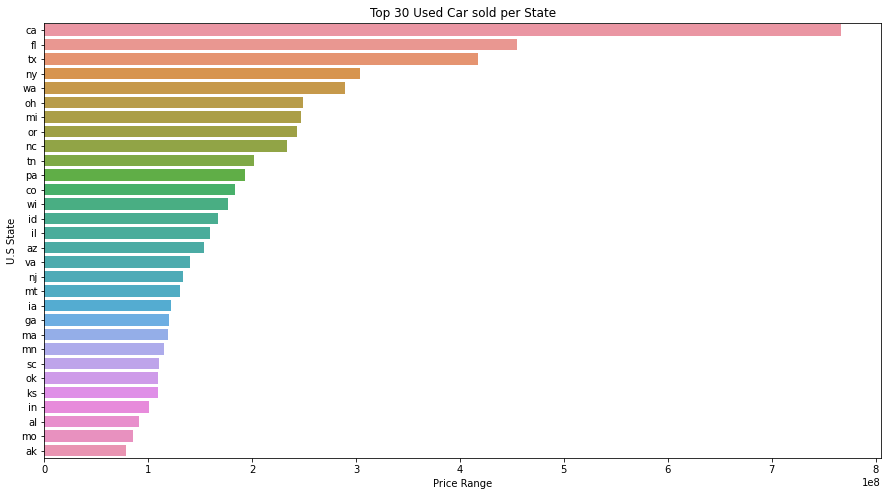

In [48]:
car_state_list = pd.DataFrame(car_data.groupby(['state'])['price_initial'].sum().sort_values(ascending=False).head(30)).reset_index()
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(y="state",x='price_initial', data=car_state_list,ax=ax)
plt.ylabel('U.S State')
plt.xlabel('Price Range')
plt.title('Top 30 Used Car sold per State')

### Feature selection

Using the feature selection methods the following features are used in modelling

'cylinders', 'odometer', 'fuel_code', 'title_status_code','transmission_code', 'drive_code', 'paint_color_code'

In [49]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 362073 entries, 27 to 426879
Data columns (total 31 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   region             362073 non-null  object  
 1   price              362073 non-null  int64   
 2   year               362073 non-null  int64   
 3   manufacturer       362073 non-null  object  
 4   model              362073 non-null  object  
 5   condition          362073 non-null  object  
 6   cylinders          362073 non-null  int64   
 7   fuel               362073 non-null  object  
 8   odometer           362073 non-null  float64 
 9   title_status       362073 non-null  object  
 10  transmission       362073 non-null  object  
 11  drive              362073 non-null  object  
 12  type               362073 non-null  object  
 13  paint_color        362073 non-null  object  
 14  state              362073 non-null  object  
 15  temp_model         362073 non-nul

Scaling price and odometer

In [50]:
scale = StandardScaler()
car_data['price'] = np.log(car_data['price'])

In [51]:
car_data['odometer'] = scale.fit_transform(np.array(car_data['odometer']).reshape(-1,1))

Mean used car price by state/region is same so removing the fields in Modeling

<AxesSubplot:>

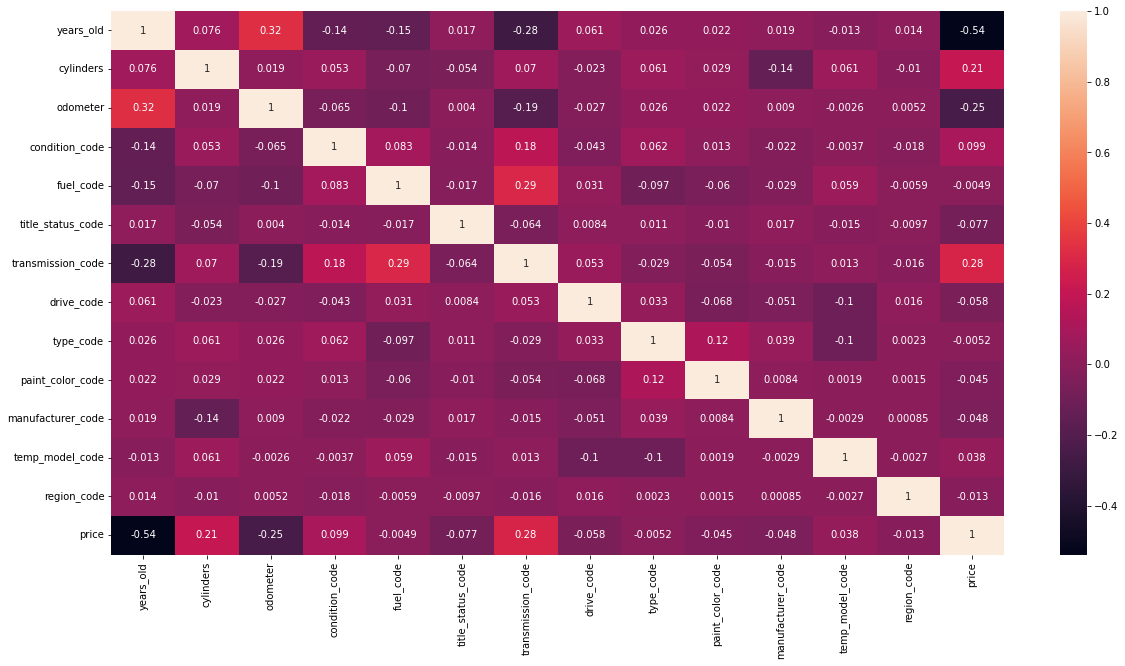

In [52]:
car_heat_map = car_data[['years_old','cylinders','odometer','condition_code','fuel_code','title_status_code','transmission_code','drive_code','type_code','paint_color_code','manufacturer_code','temp_model_code','region_code','price']]
fig, ax = plt.subplots(figsize=(20,10))  
sns.heatmap(car_heat_map.corr(),annot=True,ax=ax)

Model - years_old & odometer are Multicollinearity features, so years_old is removed.
Using permutation_importance the feature importance is derived

In [53]:
y = car_heat_map['price']
X = car_heat_map.drop(columns=['price','years_old'])
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

log_model = LinearRegression().fit(X_train, y_train)

r = permutation_importance(log_model, X_train, y_train, n_repeats = 10, random_state = 123)

pd.DataFrame({"Variable":X.columns, "Score":r.importances_mean}).sort_values(by = "Score", ascending = False)

,Variable,Score
5,transmission_code,0.121298
1,odometer,0.089661
0,cylinders,0.065661
3,fuel_code,0.016225
6,drive_code,0.009295
4,title_status_code,0.004969
8,paint_color_code,0.003485
2,condition_code,0.002262
9,manufacturer_code,0.000906
10,temp_model_code,0.000796


SequentialFeatureSelector is used to find the top 5 important features in used cars

In [54]:
sfs = SequentialFeatureSelector(LinearRegression(), n_features_to_select=7).fit(X_train, y_train)
feature_names = X_train.columns
feature_names[sfs.get_support()]

Index(['cylinders', 'odometer', 'fuel_code', 'title_status_code',
       'transmission_code', 'drive_code', 'paint_color_code'],
      dtype='object')

### Modeling

In [55]:
y = car_heat_map['price']
#X = car_heat_map.drop(columns=['price','region_code'])
X = car_heat_map[['cylinders', 'odometer', 'fuel_code', 'title_status_code', 'transmission_code','drive_code', 'paint_color_code']]
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.7, random_state = 42)

Ridge regression model

In [56]:
param = {'alpha':[.0001, 0.001,0.01, 0.01,1]}

model = Ridge()
search = GridSearchCV(model, param, scoring='r2', n_jobs=-1, cv=3)

result = search.fit(X_train, y_train)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.16701509215814647
Best Hyperparameters: {'alpha': 1}


Lasso regression model

In [57]:
param = {'alpha':[.0001, 0.001,0.01, 0.01,1]}

model = Lasso()
search = GridSearchCV(model, param, scoring='r2', n_jobs=-1, cv=3)

result = search.fit(X_train, y_train)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.1670281167099165
Best Hyperparameters: {'alpha': 0.001}


Linear regression model

In [58]:
result = LinearRegression().fit(X_train, y_train)
score = result.score(X_train, y_train)
y_pred = result.predict(X_test)
print('Score: %s' % score)

Score: 0.16932290357327184


In [59]:
result.coef_

array([ 0.13742378, -0.20814879, -0.12197461, -0.06925032,  0.33766043,
       -0.09100953, -0.01053939])